# Python: Real-Data Example for Multi-Period Difference-in-Differences

In this example, we replicate a [real-data demo notebook](https://bcallaway11.github.io/did/articles/did-basics.html#an-example-with-real-data) from the [did-R-package](https://bcallaway11.github.io/did/index.html) in order to illustrate the use of `DoubleML` for multi-period difference-in-differences (DiD) models. 



The notebook requires the following packages:

In [1]:
import pyreadr
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import LassoCV, LogisticRegressionCV

from doubleml.data import DoubleMLPanelData
from doubleml.did import DoubleMLDIDMulti

## Causal Research Question

[Callaway and Sant'Anna (2021)](https://doi.org/10.1016/j.jeconom.2020.12.001) study the causal effect of raising the minimum wage on teen employment in the US using county data over a period from 2001 to 2007. A county is defined as treated if the minimum wage in that county is above the federal minimum wage. We focus on a preprocessed balanced panel data set as provided by the [did-R-package](https://bcallaway11.github.io/did/index.html). The corresponding documentation for the `mpdta` data is available from the [did package website](https://bcallaway11.github.io/did/reference/mpdta.html). We use this data solely as a demonstration example to help readers understand differences in the `DoubleML` and `did` packages. An analogous notebook using the same data is available from the [did documentation](https://bcallaway11.github.io/did/articles/did-basics.html#an-example-with-real-data).

We follow the original notebook and provide results under identification based on unconditional and conditional parallel trends. For the Double Machine Learning (DML) Difference-in-Differences estimator, we demonstrate two different specifications, one based on linear and logistic regression and one based on their $\ell_1$ penalized variants Lasso and logistic regression with cross-validated penalty choice. The results for the former are expected to be very similar to those in the [did data example](https://bcallaway11.github.io/did/articles/did-basics.html#an-example-with-real-data). Minor differences might arise due to the use of sample-splitting in the DML estimation.


## Data

We will download and read a preprocessed data file as provided by the [did-R-package](https://bcallaway11.github.io/did/index.html).


In [2]:
# download file from did package for R
url = "https://github.com/bcallaway11/did/raw/refs/heads/master/data/mpdta.rda"
pyreadr.download_file(url, "mpdta.rda")

mpdta = pyreadr.read_r("mpdta.rda")["mpdta"]
mpdta.head()


,year,countyreal,lpop,lemp,first.treat,treat
0,2003,8001.0,5.896761,8.461469,2007.0,1.0
1,2004,8001.0,5.896761,8.336870,2007.0,1.0
2,2005,8001.0,5.896761,8.340217,2007.0,1.0
3,2006,8001.0,5.896761,8.378161,2007.0,1.0
4,2007,8001.0,5.896761,8.487352,2007.0,1.0


To work with [DoubleML](https://docs.doubleml.org/stable/index.html), we initialize a `DoubleMLPanelData` object. The input data has to satisfy some requirements, i.e., it should be in a *long* format with every row containing the information of one unit at one time period. Moreover, the data should contain a column on the unit identifier and a column on the time period. The requirements are virtually identical to those of the [did-R-package](https://bcallaway11.github.io/did/index.html), as listed in [their data example](https://bcallaway11.github.io/did/articles/did-basics.html#an-example-with-real-data). In line with the naming conventions of  [DoubleML](https://docs.doubleml.org/stable/index.html), the treatment group indicator is passed to `DoubleMLPanelData`  by the `d_cols` argument. To flexibly handle different formats for handling time periods, the time variable `t_col` can handle `float`, `int` and `datetime` formats. More information are available in the [user guide](https://docs.doubleml.org/dev/guide/data_backend.html#doublemlpaneldata). To indicate never treated units, we set their value for the treatment group variable to `np.inf`.

Now, we can initialize the ``DoubleMLPanelData`` object, specifying

 - `y_col` : the outcome
 - `d_cols`: the group variable indicating the first treated period for each unit
 - `id_col`: the unique identification column for each unit
 - `t_col` : the time column
 - `x_cols`: the additional pre-treatment controls


In [3]:
# Set values for treatment group indicator for never-treated to np.inf
mpdta.loc[mpdta['first.treat'] == 0, 'first.treat'] = np.inf

dml_data = DoubleMLPanelData(
    data=mpdta,
    y_col="lemp",
    d_cols="first.treat",
    id_col="countyreal",
    t_col="year",
    x_cols=['lpop']
)
print(dml_data)

================== DoubleMLPanelData Object ==================

------------------ Data summary      ------------------
Outcome variable: lemp
Treatment variable(s): ['first.treat']
Covariates: ['lpop']
Instrument variable(s): None
Time variable: year
Id variable: countyreal
No. Observations: 500

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Columns: 6 entries, year to treat
dtypes: float64(5), int32(1)
memory usage: 107.6 KB



Note that we specified a pre-treatment confounding variable `lpop` through the `x_cols` argument. To consider cases under unconditional parallel trends, we can use dummy learners to ignore the pre-treatment confounding variable. This is illustrated below.

## ATT Estimation: Unconditional Parallel Trends

We start with identification under the unconditional parallel trends assumption. To do so, initialize a `DoubleMLDIDMulti` object (see [model documentation](https://docs.doubleml.org/stable/guide/models.html#difference-in-differences-models-did)), which takes the previously initialized `DoubleMLPanelData` object as input. We use scikit-learn's `DummyRegressor` (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html)) and `DummyClassifier` (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)) to ignore the pre-treatment confounding variable. At this stage, we can also pass further options, for example specifying the number of folds and repetitions used for cross-fitting. 

When calling the `fit()` method, the model estimates standard combinations of $ATT(g,t)$ parameters, which corresponds to the defaults in the [did-R-package](https://bcallaway11.github.io/did/index.html). These combinations can also be customized through the `gt_combinations` argument, see [the user guide](https://docs.doubleml.org/stable/guide/models.html#panel-data).

In [4]:
dml_obj = DoubleMLDIDMulti(
    obj_dml_data=dml_data,
    ml_g=DummyRegressor(),
    ml_m=DummyClassifier(),
    control_group="never_treated",
    n_folds=10
)

dml_obj.fit()
print(dml_obj.summary.round(4))

                         coef  std err       t   P>|t|   2.5 %  97.5 %
ATT(2004.0,2003,2004) -0.0105   0.0231 -0.4545  0.6495 -0.0558  0.0348
ATT(2004.0,2003,2005) -0.0704   0.0309 -2.2767  0.0228 -0.1310 -0.0098
ATT(2004.0,2003,2006) -0.1373   0.0366 -3.7487  0.0002 -0.2091 -0.0655
ATT(2004.0,2003,2007) -0.1008   0.0342 -2.9468  0.0032 -0.1678 -0.0337
ATT(2006.0,2003,2004)  0.0065   0.0233  0.2792  0.7801 -0.0392  0.0523
ATT(2006.0,2004,2005) -0.0027   0.0196 -0.1399  0.8887 -0.0412  0.0357
ATT(2006.0,2005,2006) -0.0046   0.0179 -0.2580  0.7964 -0.0397  0.0304
ATT(2006.0,2005,2007) -0.0413   0.0202 -2.0465  0.0407 -0.0808 -0.0017
ATT(2007.0,2003,2004)  0.0304   0.0150  2.0231  0.0431  0.0009  0.0599
ATT(2007.0,2004,2005) -0.0028   0.0164 -0.1712  0.8640 -0.0350  0.0294
ATT(2007.0,2005,2006) -0.0311   0.0179 -1.7361  0.0825 -0.0662  0.0040
ATT(2007.0,2006,2007) -0.0261   0.0167 -1.5624  0.1182 -0.0588  0.0066


The summary displays estimates of the $ATT(g,t_\text{eval})$ effects for different combinations of $(g,t_\text{eval})$ via $\widehat{ATT}(\mathrm{g},t_\text{pre},t_\text{eval})$, where
 - $\mathrm{g}$ specifies the group
 - $t_\text{pre}$ specifies the corresponding pre-treatment period
 - $t_\text{eval}$ specifies the evaluation period

This corresponds to the estimates given in `att_gt` function in the [did-R-package](https://bcallaway11.github.io/did/index.html), where the standard choice is $t_\text{pre} = \min(\mathrm{g}, t_\text{eval}) - 1$ (without anticipation).

Remark that this includes pre-tests effects if $\mathrm{g} > t_{eval}$, e.g. $ATT(2007,2005)$.

As usual for the DoubleML-package, you can obtain joint confidence intervals via bootstrap.

In [5]:
level = 0.95

ci = dml_obj.confint(level=level)
dml_obj.bootstrap(n_rep_boot=5000)
ci_joint = dml_obj.confint(level=level, joint=True)
print(ci_joint)

                          2.5 %    97.5 %
ATT(2004.0,2003,2004) -0.076141  0.055152
ATT(2004.0,2003,2005) -0.158338  0.017515
ATT(2004.0,2003,2006) -0.241445 -0.033176
ATT(2004.0,2003,2007) -0.197994 -0.003549
ATT(2006.0,2003,2004) -0.059827  0.072855
ATT(2006.0,2004,2005) -0.058563  0.053068
ATT(2006.0,2005,2006) -0.055470  0.046240
ATT(2006.0,2005,2007) -0.098580  0.016058
ATT(2007.0,2003,2004) -0.012340  0.073232
ATT(2007.0,2004,2005) -0.049489  0.043866
ATT(2007.0,2005,2006) -0.082067  0.019838
ATT(2007.0,2006,2007) -0.073517  0.021370


A visualization of the effects can be obtained via the `plot_effects()` method.

Remark that the plot used joint confidence intervals per default. 

/opt/hostedtoolcache/Python/3.12.10/x64/lib/python3.12/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


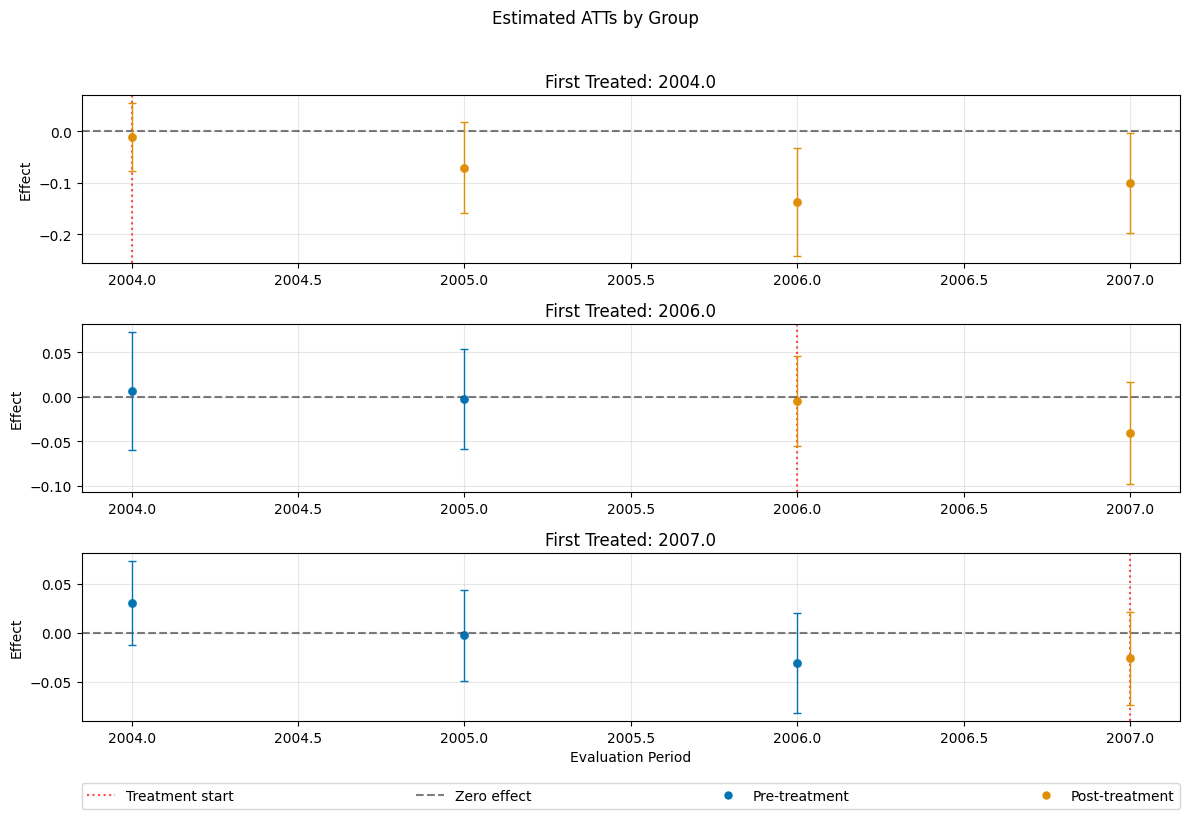

In [6]:
fig, ax = dml_obj.plot_effects()

## Effect Aggregation

As the [did-R-package](https://bcallaway11.github.io/did/index.html), the $ATT$'s can be aggregated to summarize multiple effects.
For details on different aggregations and details on their interpretations see [Callaway and Sant'Anna(2021)](https://doi.org/10.1016/j.jeconom.2020.12.001).

The aggregations are implemented via the `aggregate()` method. We follow the structure of the [did package notebook](https://bcallaway11.github.io/did/articles/did-basics.html#an-example-with-real-data) and start with an aggregation relative to the treatment timing.

### Event Study Aggregation


We can aggregate the $ATT$s relative to the treatment timing. This is done by setting `aggregation="eventstudy"` in the `aggregate()` method. 
 `aggregation="eventstudy"` aggregates $\widehat{ATT}(\mathrm{g},t_\text{pre},t_\text{eval})$ based on exposure time $e = t_\text{eval} - \mathrm{g}$ (respecting group size).

================== DoubleMLDIDAggregation Object ==================
 Event Study Aggregation 

------------------ Overall Aggregated Effects ------------------
     coef  std err         t    P>|t|     2.5 %    97.5 %
-0.077252 0.020016 -3.859566 0.000114 -0.116482 -0.038022
------------------ Aggregated Effects         ------------------
          coef   std err         t     P>|t|     2.5 %    97.5 %
-3.0  0.030446  0.015050  2.023061  0.043067  0.000950  0.059943
-2.0 -0.000630  0.013301 -0.047369  0.962219 -0.026699  0.025439
-1.0 -0.024479  0.014246 -1.718333  0.085736 -0.052400  0.003442
0.0  -0.019948  0.011833 -1.685742  0.091845 -0.043141  0.003245
1.0  -0.050978  0.016748 -3.043791  0.002336 -0.083804 -0.018152
2.0  -0.137310  0.036629 -3.748717  0.000178 -0.209101 -0.065520
3.0  -0.100772  0.034197 -2.946763  0.003211 -0.167797 -0.033746
------------------ Additional Information     ------------------
Score function: observational
Control group: never_treated
Anticipation pe

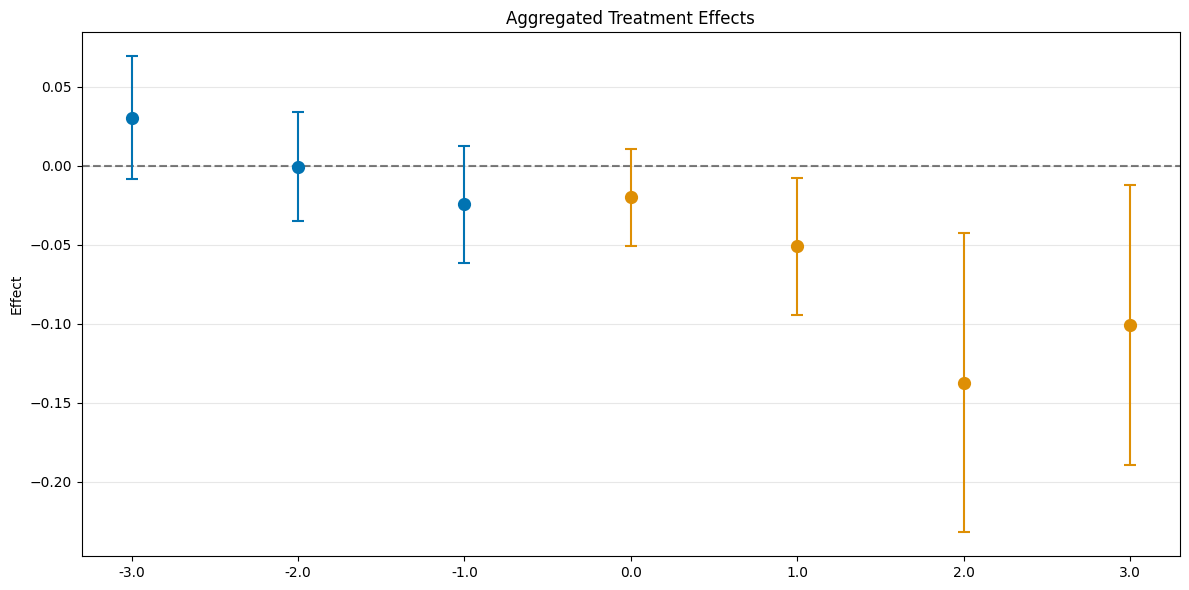

In [7]:
# rerun bootstrap for valid simultaneous inference (as values are not saved) 
dml_obj.bootstrap(n_rep_boot=5000)
aggregated_eventstudy = dml_obj.aggregate("eventstudy")
# run bootstrap to obtain simultaneous confidence intervals
aggregated_eventstudy.aggregated_frameworks.bootstrap()
print(aggregated_eventstudy)
fig, ax = aggregated_eventstudy.plot_effects()

Alternatively, the $ATT$ could also be aggregated according to (calendar) time periods or treatment groups, see the [user guide](https://docs.doubleml.org/dev/guide/models.html#effect-aggregation).

### Aggregation Details

The `DoubleMLDIDAggregation` objects include several `DoubleMLFrameworks` which support methods like `bootstrap()` or `confint()`.
Further, the weights can be accessed via the properties

 - ``overall_aggregation_weights``: weights for the overall aggregation
 - ``aggregation_weights``: weights for the aggregation

To clarify, e.g. for the eventstudy aggregation

If one would like to consider how the aggregated effect with $e=0$ is computed, one would have to look at the third set of weights within the ``aggregation_weights`` property

In [8]:
aggregated_eventstudy.aggregation_weights[2]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.23391813, 0.        , 0.        , 0.        , 0.        ,
       0.76608187, 0.        ])

## ATT Estimation: Conditional Parallel Trends

We briefly demonstrate how to use the `DoubleMLDIDMulti` model with conditional parallel trends. As the rationale behind DML is to flexibly model nuisance components as prediction problems, the DML DiD estimator includes pre-treatment covariates by default. In DiD, the nuisance components are the outcome regression and the propensity score estimation for the treatment group variable. This is why we had to enforce dummy learners in the unconditional parallel trends case to ignore the pre-treatment covariates. Now, we can replicate the classical doubly robust DiD estimator as of [Callaway and Sant'Anna(2021)](https://doi.org/10.1016/j.jeconom.2020.12.001) by using linear and logistic regression for the nuisance components. This is done by setting `ml_g` to `LinearRegression()` and `ml_m` to `LogisticRegression()`. Similarly, we can also choose other learners, for example by setting `ml_g` and `ml_m` to `LassoCV()` and `LogisticRegressionCV()`. We present the results for the ATTs and their event-study aggregation in the corresponding effect plots.

Please note that the example is meant to illustrate the usage of the `DoubleMLDIDMulti` model in combination with ML learners. In real-data applicatoins, careful choice and empirical evaluation of the learners are required. Default measures for the prediction of the nuisance components are printed in the model summary, as briefly illustrated below.

/opt/hostedtoolcache/Python/3.12.10/x64/lib/python3.12/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


(<Figure size 1200x800 with 4 Axes>,
 [<Axes: title={'center': 'First Treated: 2004.0'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2006.0'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2007.0'}, xlabel='Evaluation Period', ylabel='Effect'>])

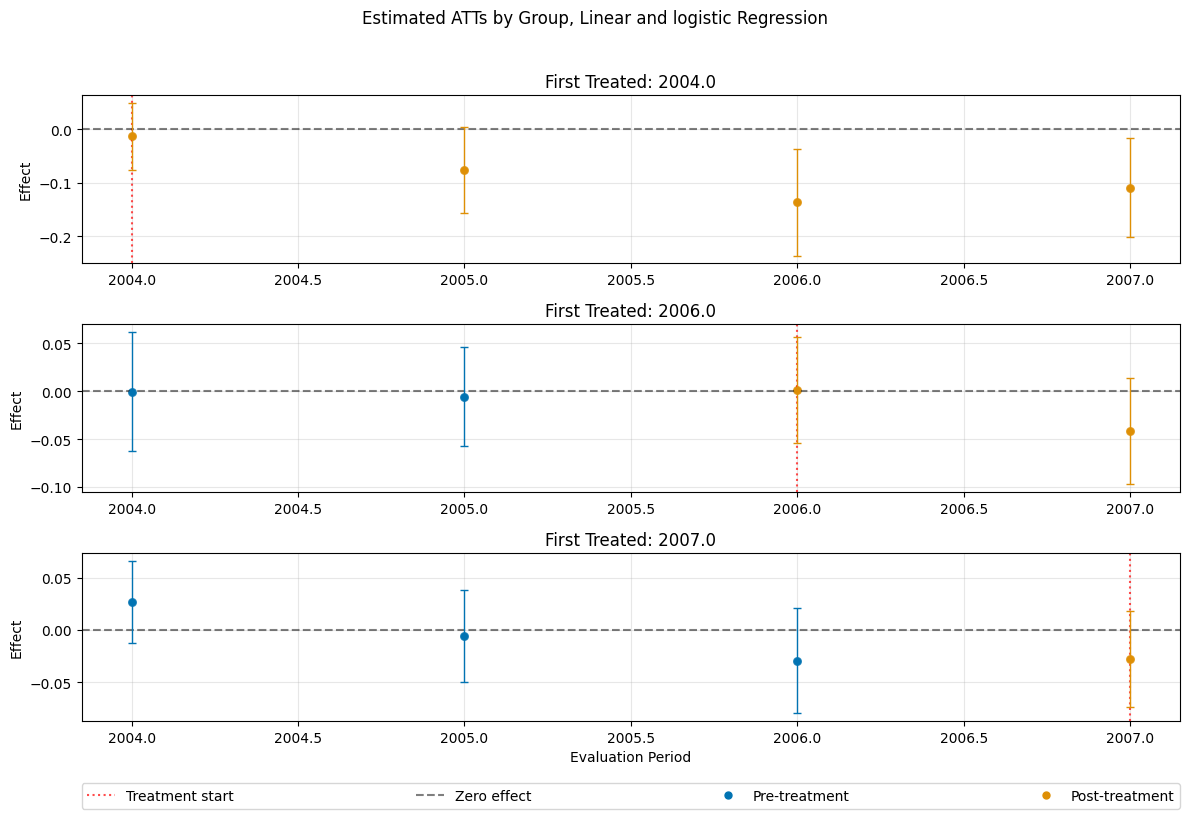

In [9]:
dml_obj_linear_logistic = DoubleMLDIDMulti(
    obj_dml_data=dml_data,
    ml_g=LinearRegression(),
    ml_m=LogisticRegression(penalty=None),
    control_group="never_treated",
    n_folds=10
)

dml_obj_linear_logistic.fit()
dml_obj_linear_logistic.bootstrap(n_rep_boot=5000)
dml_obj_linear_logistic.plot_effects(title="Estimated ATTs by Group, Linear and logistic Regression")


We briefly look at the model summary, which includes some standard diagnostics for the prediction of the nuisance components.

In [10]:
print(dml_obj_linear_logistic)

================== DoubleMLDIDMulti Object ==================

------------------ Data summary      ------------------
Outcome variable: lemp
Treatment variable(s): ['first.treat']
Covariates: ['lpop']
Instrument variable(s): None
Time variable: year
Id variable: countyreal
No. Observations: 500

------------------ Score & algorithm ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0

------------------ Machine learner   ------------------
Learner ml_g: LinearRegression()
Learner ml_m: LogisticRegression(penalty=None)
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[0.17222386 0.1818565  0.25944108 0.25789031 0.17250893 0.15079692
  0.20100013 0.20663723 0.1721163  0.15116655 0.20112221 0.16429369]]
Learner ml_g1 RMSE: [[0.09955575 0.12805908 0.13808264 0.14995326 0.13713356 0.11119891
  0.08745716 0.10464399 0.13907284 0.16234709 0.16133341 0.16188834]]
Classification:
Learner ml_m Log Loss: [[0.23189549 0.23086924 0.231319

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Estimated ATTs by Group, Linear and logistic Regression'}, ylabel='Effect'>)

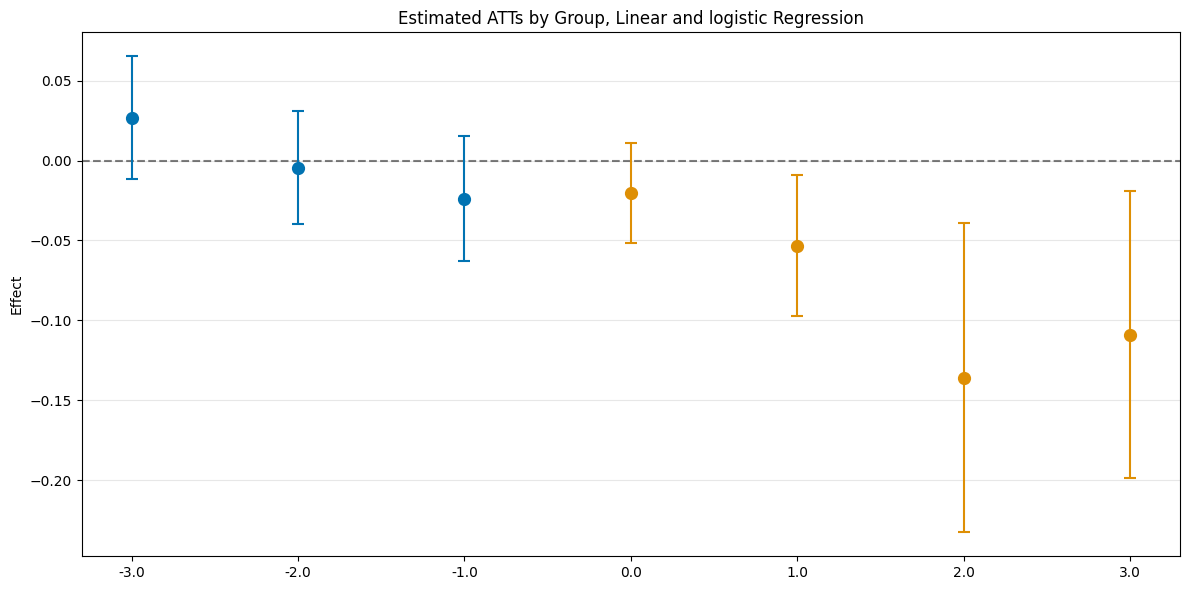

In [11]:
es_linear_logistic = dml_obj_linear_logistic.aggregate("eventstudy")
es_linear_logistic.aggregated_frameworks.bootstrap()
es_linear_logistic.plot_effects(title="Estimated ATTs by Group, Linear and logistic Regression")

/opt/hostedtoolcache/Python/3.12.10/x64/lib/python3.12/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


(<Figure size 1200x800 with 4 Axes>,
 [<Axes: title={'center': 'First Treated: 2004.0'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2006.0'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2007.0'}, xlabel='Evaluation Period', ylabel='Effect'>])

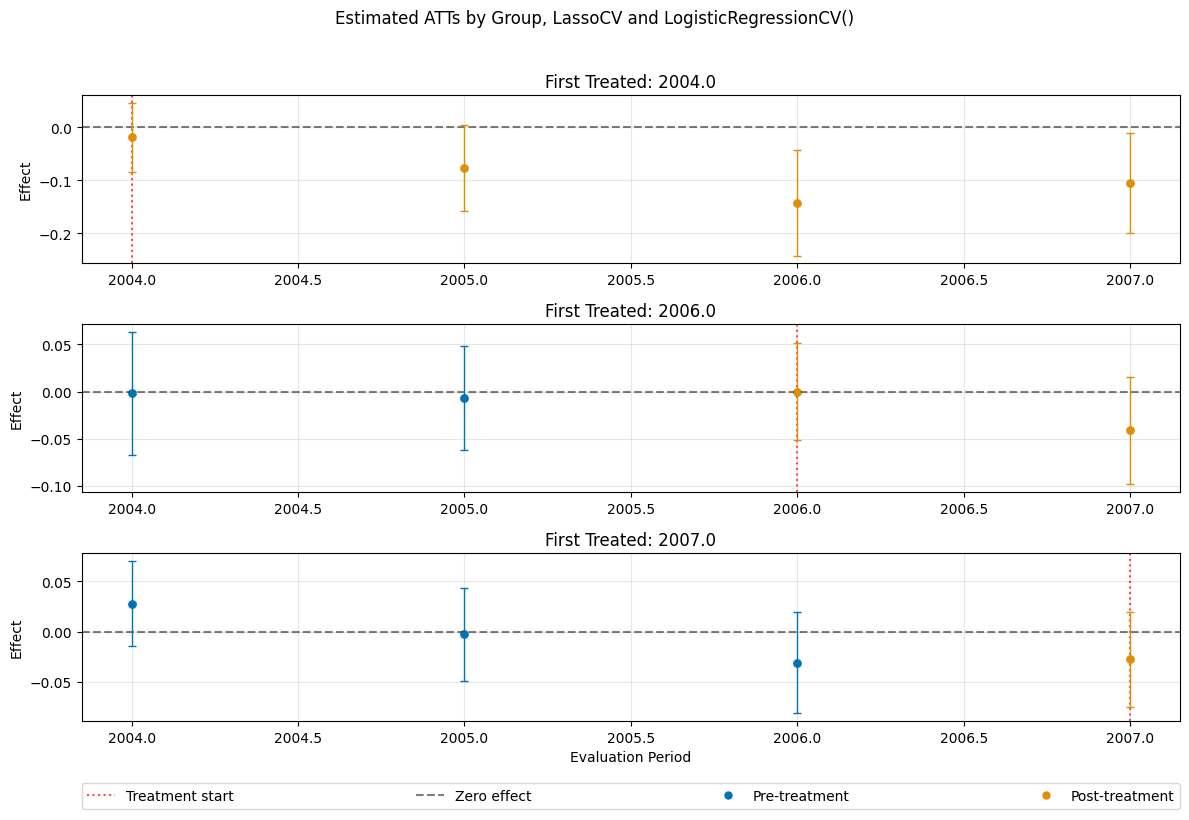

In [12]:
dml_obj_lasso = DoubleMLDIDMulti(
    obj_dml_data=dml_data,
    ml_g=LassoCV(),
    ml_m=LogisticRegressionCV(),
    control_group="never_treated",
    n_folds=10
)

dml_obj_lasso.fit()
dml_obj_lasso.bootstrap(n_rep_boot=5000)
dml_obj_lasso.plot_effects(title="Estimated ATTs by Group, LassoCV and LogisticRegressionCV()")


In [13]:
# Model summary
print(dml_obj_lasso)

================== DoubleMLDIDMulti Object ==================

------------------ Data summary      ------------------
Outcome variable: lemp
Treatment variable(s): ['first.treat']
Covariates: ['lpop']
Instrument variable(s): None
Time variable: year
Id variable: countyreal
No. Observations: 500

------------------ Score & algorithm ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0

------------------ Machine learner   ------------------
Learner ml_g: LassoCV()
Learner ml_m: LogisticRegressionCV()
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[0.17331072 0.18188933 0.26003003 0.25794233 0.17267649 0.15194435
  0.2024767  0.20619395 0.17429751 0.15282714 0.20075433 0.16534468]]
Learner ml_g1 RMSE: [[0.10217733 0.12171378 0.14476628 0.15419585 0.13887325 0.11142262
  0.08827953 0.10665474 0.13142371 0.16098131 0.158558   0.15901852]]
Classification:
Learner ml_m Log Loss: [[0.22913945 0.22913699 0.22913845 0.22913738 0.355

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Estimated ATTs by Group, LassoCV and LogisticRegressionCV()'}, ylabel='Effect'>)

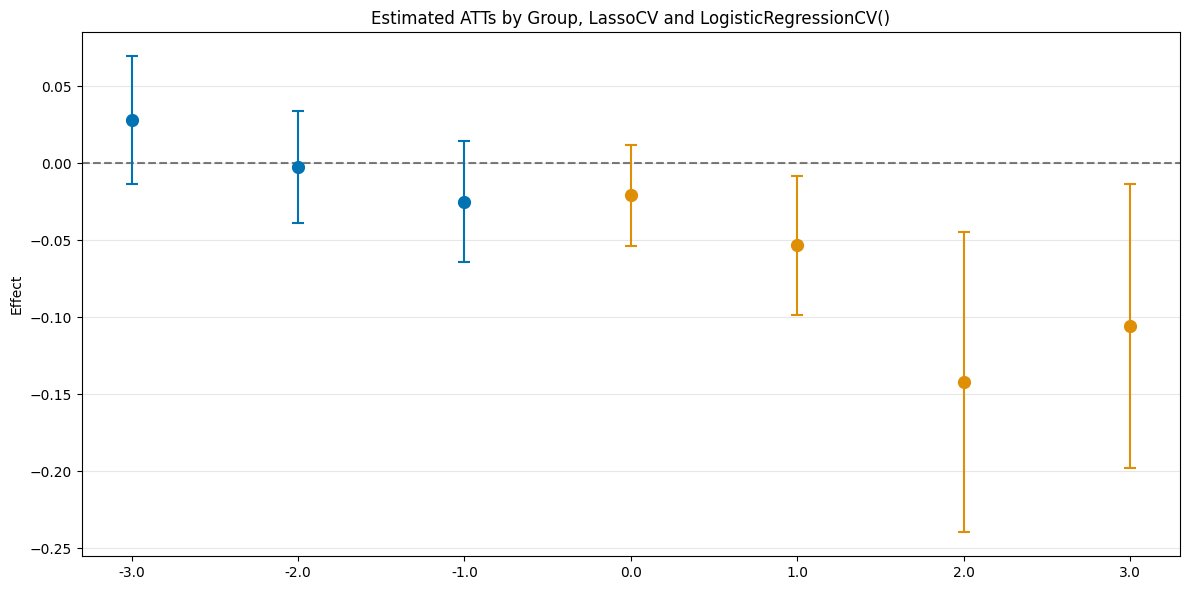

In [14]:
es_rf = dml_obj_lasso.aggregate("eventstudy")
es_rf.aggregated_frameworks.bootstrap()
es_rf.plot_effects(title="Estimated ATTs by Group, LassoCV and LogisticRegressionCV()")